### LSTM Regression

In [1]:
import torch
from torch import nn, optim

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = [12,8]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

In [2]:

data = sns.load_dataset("flights")
print(f'Number of Entries: {len(data)}')
data.head()

Number of Entries: 144


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


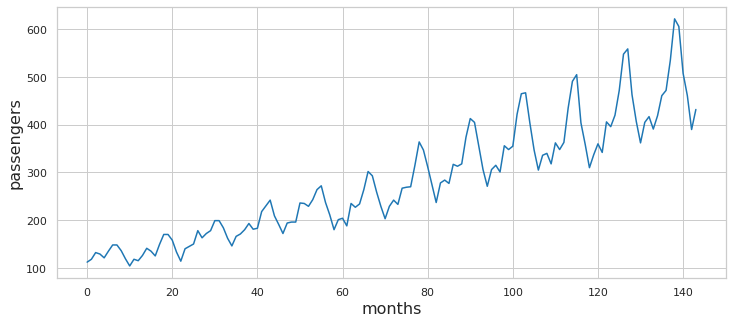

In [3]:

plt.figure(figsize=[12., 5.])
ax = sns.lineplot(data.index, data.passengers, data=data)
ax.set_xlabel('months');

In [4]:
# Convert passenter data to float32 for PyTorch
data.passengers = data.passengers.astype(np.float32)

# Reserve last 12 months as test set:
train_data = data.passengers[:-12].to_numpy().reshape(-1, 1)
valid_data = data.passengers[-12:].to_numpy().reshape(-1, 1)

# scale data
t_scaler = MinMaxScaler(feature_range=(-1, 1))
v_scaler = MinMaxScaler(feature_range=(-1, 1))
train_data = t_scaler.fit_transform(train_data)
valid_data = v_scaler.fit_transform(valid_data)

# convert training data to tensor
train_data = torch.tensor(train_data, dtype=torch.float32)
valid_data = torch.tensor(valid_data, dtype=torch.float32)

In [5]:

# Create validation set:
valid_x = valid_data[:-1]
valid_y = valid_data[1:]
valid_data = (valid_x, valid_y)

In [6]:
def get_batches(data, window):
    """
    Takes data with shape (n_samples, n_features) and creates mini-batches
    with shape (1, window). 
    """

    L = len(data)
    for i in range(L - window):
        x_sequence = data[i:i + window]
        y_sequence = data[i+1: i + window + 1] 
        yield x_sequence, y_sequence

In [59]:

class flightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        # Put your code here
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first= True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hs):
        # Put your code here
        out, hidden = self.lstm(x, hs)
        out = out.view(-1, self.hidden_size) 
        out = self.fc(out)
        
        return out, hidden

In [60]:
input_size = 1
hidden_size = 100
num_layers = 1
output_size = 1

model = flightLSTM(input_size, hidden_size, num_layers, output_size)

In [38]:
def train(model, epochs, train_set, valid_data=None, lr=0.001, print_every=100):

    criterion = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    
    train_loss = []
    valid_loss = []
    
    for e in range(epochs):
        
        hs = None
        t_loss = 0
        for x, y in get_batches(train_set, 12):

            opt.zero_grad()
            
            # Create batch_size dimension
            x = x.unsqueeze(0)
            out, hs = model(x, hs)
            hs = tuple([h.data for h in hs])
            
            loss = criterion(out, y)
            loss.backward()
            opt.step()
            t_loss += loss.item()
            
        if valid_data is not None:
                model.eval()
                val_x, val_y = valid_data
                val_x = val_x.unsqueeze(0)
                preds, _ = model(val_x, hs)
                v_loss = criterion(preds, val_y)
                valid_loss.append(v_loss.item())
                
                model.train()
            
        train_loss.append(np.mean(t_loss))
            
            
        if e % print_every == 0:
            print(f'Epoch {e}:\nTraining Loss: {train_loss[-1]}')
            if valid_data is not None:
                print(f'Validation Loss: {valid_loss[-1]}')
    
    plt.figure(figsize=[8., 6.])
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.show()

Epoch 0:
Training Loss: 20.846546502783895
Validation Loss: 0.5075258612632751
Epoch 100:
Training Loss: 1.0422432054765522
Validation Loss: 0.12743395566940308
Epoch 200:
Training Loss: 1.0701504456810653
Validation Loss: 0.22015927731990814
Epoch 300:
Training Loss: 0.6656516285147518
Validation Loss: 0.26421716809272766
Epoch 400:
Training Loss: 0.6706932494416833
Validation Loss: 0.27642178535461426


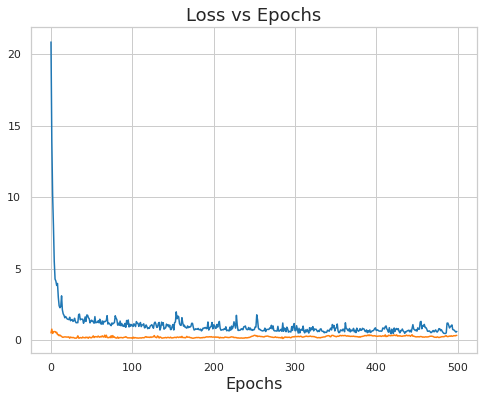

In [61]:
train(model, 500, train_data, lr=0.0005, valid_data=valid_data)

In [41]:
print(train_data.shape)
print(valid_x.shape)

torch.Size([132, 1])
torch.Size([11, 1])


In [62]:

# get predictions on training set
hs = None
train_preds, hs = model(train_data.unsqueeze(0), hs)
train_preds = t_scaler.inverse_transform(train_preds.detach())

# Get predictions on validation data
valid_preds, hs = model(valid_x.unsqueeze(0), hs)
valid_preds = v_scaler.inverse_transform(valid_preds.detach())

In [63]:
train_time = data.index[1:-11]
valid_time = data.index[-11:]

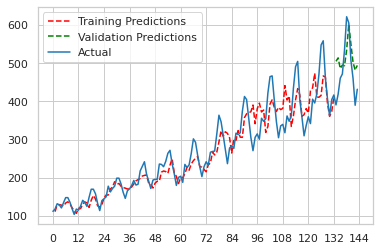

In [64]:
plt.plot(train_time, train_preds.squeeze(), 'r--', label='Training Predictions', )
plt.plot(valid_time, valid_preds.squeeze(), 'g--', label='Validation Predictions')
plt.plot(data.index, data.passengers.to_numpy(), label='Actual')
plt.xticks(np.arange(0,145,12))
plt.legend()